# Monroe County crash data exploration
Preliminary cleaning/exploring the car crash data for Monroe County, IN. (https://data.bloomington.in.gov/dataset/traffic-data)

This notebook will start by looking at the 2022 data, saved in the `source-data` file as `moco-crash-2022.csv`. We will see what information this data can show, and explain some caveats.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import re
from datetime import date, time

pd.set_option('display.max_columns', None)

In [2]:
# read in the csv
crash_df = pd.read_csv('../data/source-data/moco-crash-2022.csv')  
# take a look at the data types to see what is included in the data
crash_df.dtypes

Agency                       object
Local Code                   object
County                       object
Township                     object
City                         object
Collision Date               object
Collision Time               object
Vehicles Involved             int64
Trailers Involved           float64
Number Injured                int64
Number Dead                   int64
Number Deer                   int64
House Number                 object
Roadway Name                 object
Roadway Suffix               object
Roadway Number               object
Roadway Interchange          object
Roadway Ramp                 object
Roadway Id                   object
Intersecting Road            object
Intersecting Road Number    float64
Mile Marker                 float64
Interchange                 float64
Corporate Limits?            object
Property Type                object
Feet From                   float64
Direction                    object
Latitude                    

In [3]:
crash_df.describe()

,Vehicles Involved,Trailers Involved,Number Injured,Number Dead,Number Deer,Intersecting Road Number,Mile Marker,Interchange,Feet From,Latitude,Longitude,Type of Median,State Property Damage?
count,3646.000000,108.000000,3646.000000,3646.000000,3646.000000,0.0,95.000000,0.0,3572.000000,3559.000000,3559.000000,0.0,3646.000000
mean,1.797861,0.009259,0.247394,0.003566,0.048272,NaN,120.449474,NaN,93.594625,37.857818,-83.649525,NaN,0.024959
std,0.546349,0.096225,0.596940,0.059614,0.215646,NaN,101.542324,NaN,340.795100,7.043217,15.560970,NaN,0.166237
min,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,-94.221107,NaN,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,106.250000,NaN,0.000000,39.146647,-86.569313,NaN,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,NaN,115.000000,NaN,0.000000,39.164462,-86.533720,NaN,0.000000
75%,2.000000,0.000000,0.000000,0.000000,0.000000,NaN,123.000000,NaN,0.000000,39.176639,-86.512502,NaN,0.000000
max,8.000000,1.000000,7.000000,1.000000,2.000000,NaN,920.000000,NaN,9500.000000,42.845800,0.000000,NaN,4.000000


Looks like we've got a dataset with 3,057 records. Each car crash has info about when it happened, where it happened and how it happened. There are several different columns describing the location/conditions, including `Roadway Class`, `Construction?`, `School Zone?` and `Number Deer`. There's also latitude and longitude for most rows, which will be helpful for mapping the crashes. 

I'm intrigued by the `Number Deer` category — it seems like deer-involved crashes must happen a lot to be included in this city dataset.

In [4]:
crash_df['Number Deer'].where(crash_df['Number Deer'] > 0).count() / crash_df['Number Deer'].count()

0.047997805814591336

Looks like deer were involved in 4.8% of crashes last year. Interesting!

Let's see how many records actually have latitude/longitude coordinates. Missing data will affect the robustness of mapping visualizations when visualizing this dataset.

In [5]:
print('Total rows:', crash_df.shape[0], '\nRows w lat/lon:', crash_df['Latitude'].dropna().count())
print('% w lat/lon:', "{0:.2f}".format( crash_df['Latitude'].dropna().count() / crash_df.shape[0] * 100) + "%")

Total rows: 3646 
Rows w lat/lon: 3559
% w lat/lon: 97.61%


The vast majority have lat/lon data for last year, so that's great!

Let's take a closer look at some of the columns, and see how useful they might be.

In [6]:
crash_df.count()

Agency                      3646
Local Code                  3646
County                      3646
Township                    3577
City                        3577
Collision Date              3646
Collision Time              3646
Vehicles Involved           3646
Trailers Involved            108
Number Injured              3646
Number Dead                 3646
Number Deer                 3646
House Number                 420
Roadway Name                3582
Roadway Suffix                63
Roadway Number                56
Roadway Interchange           25
Roadway Ramp                  27
Roadway Id                  3639
Intersecting Road           2654
Intersecting Road Number       0
Mile Marker                   95
Interchange                    0
Corporate Limits?           3642
Property Type                  9
Feet From                   3572
Direction                     34
Latitude                    3559
Longitude                   3559
Roadway Class               3370
Traffic Co

Several of these fields have very few entries, such as `Trailers Involved`, which only appears in <5% of the rows. Also, many of the fields aren't that useful, especially because their meaning can be ambiguous.

Based on the counts alone, it seems like `Trailers Involved`, `Roadway Ramp`, `House Number`, `Roadway Interchange`, `Interchange`, `Direction`, `Construction Type`, `Type of Median`, and a few others won't be useful, because they just aren't applicable to most crashes, or they weren't recorded in most reports. 

A couple of fields with very few entries, like `Hit and Run?`, would still be useful though. Hit and run crashes are likely rare, so this field would only be filled out if the case was a hit and run, making this field still useful for analysis. 

But other fields are too ambiguous to be very useful. For example, based on interviews with Bloomington city employees, `Feet From` and `Direction` can be interpreted multiple ways by law enforcement officials who fill out crash reports. Some people interpret `Feet From` as the distance between the crash and the nearest intersection, and `Direction` as a reference point for where the crash happened in relation to that intersection. For example, if a crash happened 100 feet west of 1ST and DUNN ST, one officer might log `Direction` as `W` and `Feet From` as `100`. But another officer might just log the actual location with latitude and longitude, not labeling 1ST and DUNN ST, and not including `Direction` or `Feet From`. 

Based on confusion like this, the best way to analyze the geospatial distribution of the crashes is probably through mapping rather than analyzing variables like `Feet From` and `Direction`. 

This ambiguity is why the `master-crash.csv` file excludes most of the columns, instead just keeping the road name/latitude/longitude and a few key features like fatality and injury counts for mapping purposes. If you decide to analyze some of the other fields, be careful to make sure you understand some of the caveats, which are explained in more detail in the methodology + data dictionary of this project. 

## Looking at older data

Now that we've assessed the basic features of the recent data, let's take a look at some older records. The structure of the data from the 2022 `csv` is very similar for years 2019-2021, but prior to 2018, the data looks pretty different, and from 2003-2015, it was extremely different. 

This means the older data can be difficult to compare with recent years, so it's best to be careful when looking at trends across the entire range of the data. 

Let's take a look at the 2003-2015 dataset to see some more of these caveats.

In [7]:
# read in the csv
crash_df_0315 = pd.read_csv('../data/source-data/moco-crash-2003-2015.csv', encoding='unicode_escape')  
# take a look at the data types to see what is included in the data
crash_df_0315.dtypes

Master Record Number      int64
Year                      int64
Month                     int64
Day                       int64
Weekend?                 object
Hour                    float64
Collision Type           object
Injury Type              object
Primary Factor           object
Reported_Location        object
Latitude                float64
Longitude               float64
dtype: object

It's immediately clear that there are way fewer fields in this dataset compared with 2022. But, some of these fields do offer more information that isn't available in more recent data, even if it might be a bit unclear. 

For example, this data doesn't have exact numbers for fatality or injury counts, but it offers a bit more information on the severity of injuries that resulted from crashes. 

In [8]:
# what are the possible values for injury type?
crash_df_0315['Injury Type'].unique()

array(['No injury/unknown', 'Non-incapacitating', 'Incapacitating',
       'Fatal'], dtype=object)

While this way of recording makes it harder to compare the total number of injuries or deaths from these years, it does give more information about how severe a crash was which could be useful when analyzing this dataset by itself.

In [9]:
# what are the values for `Collision Type`?
crash_df_0315['Collision Type'].unique()

array(['2-Car', '1-Car', '3+ Cars', 'Pedestrian', 'Cyclist', 'Bus',
       'Moped/Motorcycle', nan], dtype=object)

In a very similar way, the `Collision Type` field gives more information that's lacking in newer data. Namely, it flags which crashes involved pedestrians or cyclists, an important piece of data that is not automatically recorded by the newer crash reports. But, this field is still ambiguous, because if there was a crash that involved two vehicles, a pedestrian and a cyclist, it would be impossible to tell that from this data structure. We don't know how law enforcement made the decision of which value to encode for the crash, so it's unclear if pedestrian involvement would trump other flags in this category. 

However, this is still a useful way to get a bit more insight into pedestrian/cyclist involved crashes, even if it makes it harder to compare with recent data.

In [10]:
# how many crashes involved a pedestrian from 2003-2015?
crash_df_0315[crash_df_0315['Collision Type'] == 'Pedestrian'].shape[0] / crash_df_0315.shape[0]

0.011289694677715366

It looks like 1.1% of crashes over that time period were marked as pedestrian-involved crashes.

<AxesSubplot:>

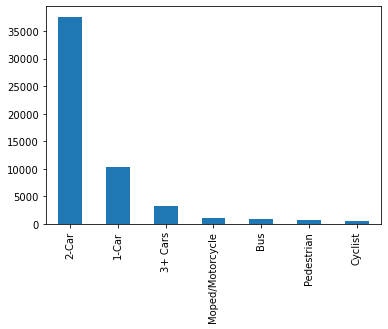

In [11]:
crash_df_0315['Collision Type'].value_counts().plot(kind='bar')